<a href="https://colab.research.google.com/github/hsnbnaa/deep-learning-is-easy/blob/main/Hands-on%20Machine%20Learning%20with%20Scikit-Learn%2C%20Keras%20%26%20TensorFlow/Chapter%2002/02_end_to_end_machine_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import tarfile
import urllib.request
import os

# Fungsi untuk mengambil dan memuat data
def load_housing_data():
    tarball_path = "datasets/housing.tgz"
    if not os.path.isdir("datasets"):
        os.makedirs("datasets")
    if not os.path.isfile(tarball_path):
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv("datasets/housing/housing.csv")

# Memuat data ke dalam variabel
housing = load_housing_data()

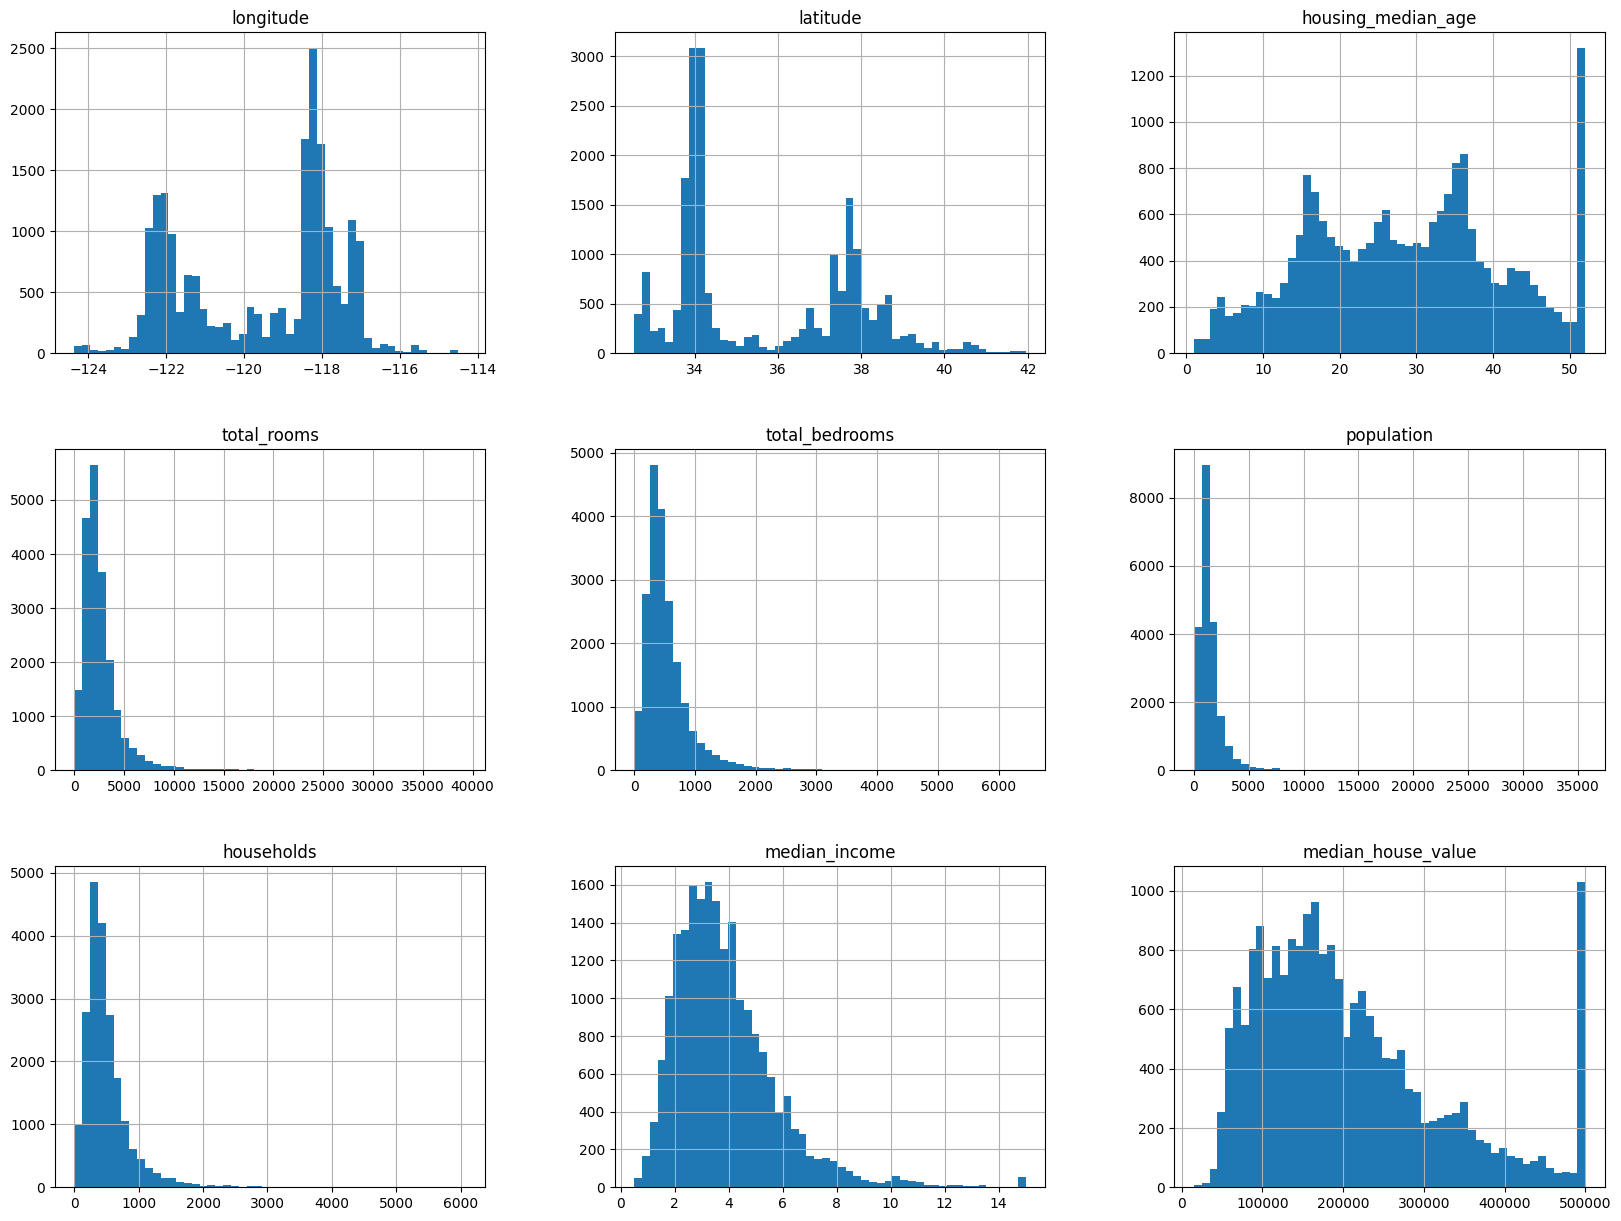

In [14]:
import matplotlib.pyplot as plt

# Mengaktifkan mode inline plotting di Jupyter
%matplotlib inline

housing.hist(bins=50, figsize=(20, 15))
plt.show()

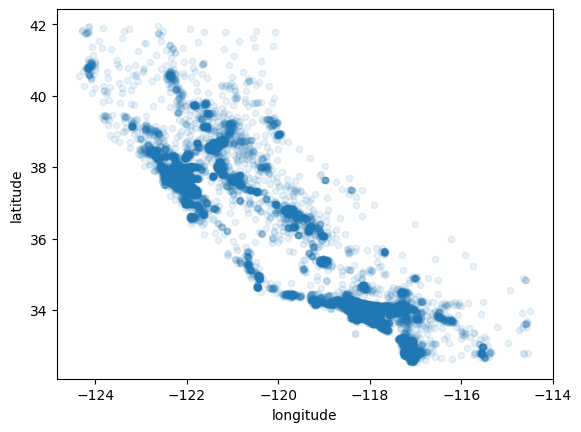

In [8]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

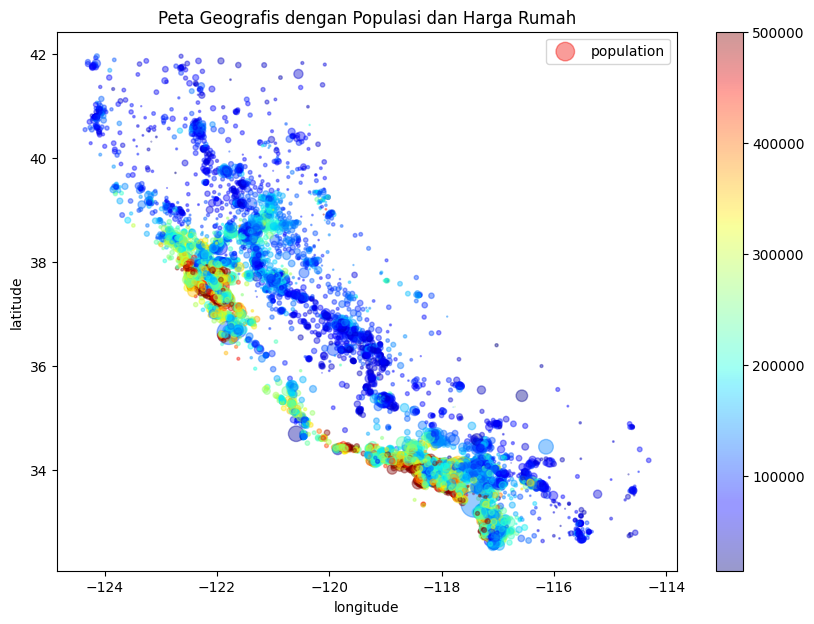

In [15]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=housing["population"] / 100,  # Ukuran titik berdasarkan populasi
    label="population",
    figsize=(10, 7),
    c=housing["median_house_value"], # <- INI BAGIAN YANG DIPERBAIKI
    cmap=plt.get_cmap("jet"),
    colorbar=True,
    sharex=False
)
plt.legend()
plt.title("Peta Geografis dengan Populasi dan Harga Rumah")
plt.show()

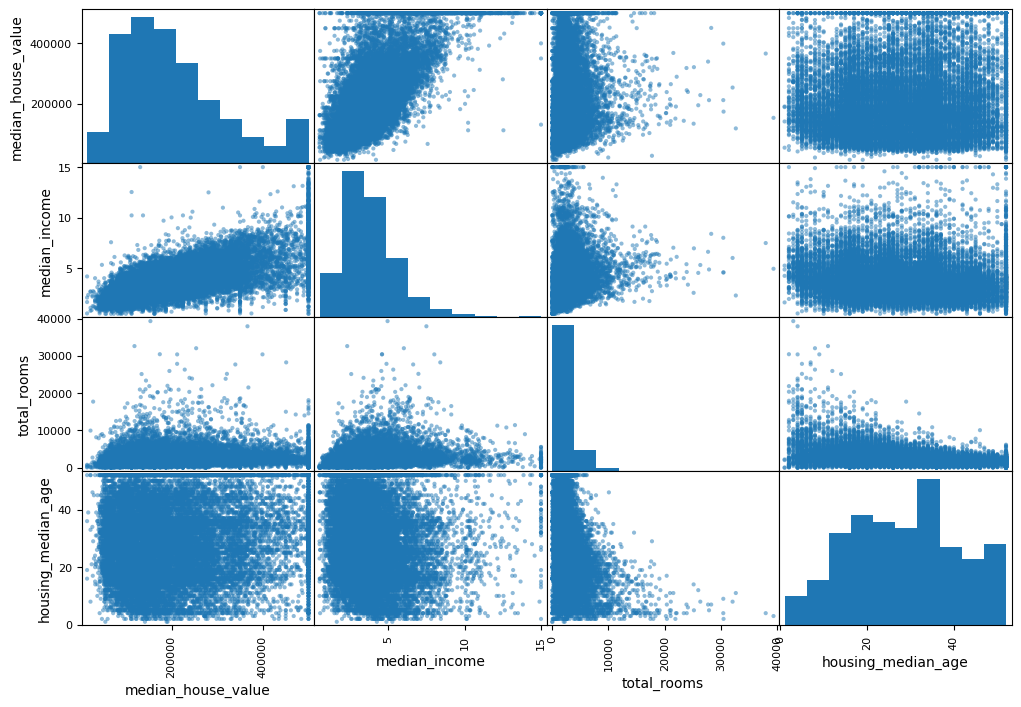

In [16]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

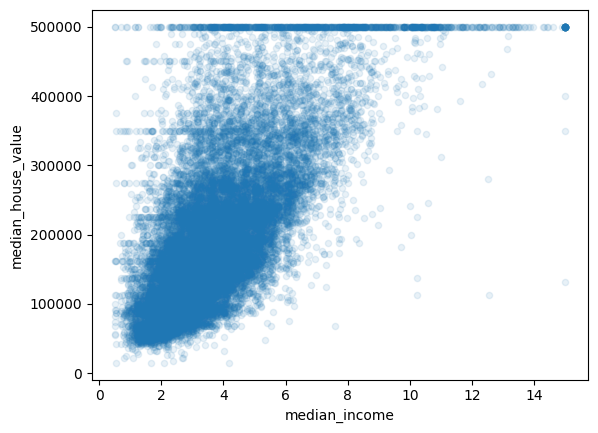

In [17]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1)
plt.show()

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np

# Membuat kategori pendapatan untuk stratified sampling
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

# Melakukan stratified split
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

# Menghapus kolom income_cat setelah split
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

# Memisahkan fitur dari label
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Pipeline untuk fitur numerik
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])

# Pipeline lengkap yang menggabungkan proses untuk data numerik dan kategorikal
num_attribs = housing.select_dtypes(include=[np.number]).columns
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

# Menjalankan pipeline pada data
housing_prepared = full_pipeline.fit_transform(housing)

In [5]:
from sklearn.ensemble import RandomForestRegressor

# Memilih model Random Forest
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

# Melatih model dengan data yang sudah diproses
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(random_state=42)

In [6]:
from sklearn.model_selection import GridSearchCV

# Daftar parameter yang akan diuji
param_grid = [
    {'n_estimators': [30, 50, 80], 'max_features': [6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor(random_state=42)

# Mencari parameter terbaik menggunakan GridSearchCV
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

# Model terbaik yang ditemukan
final_model = grid_search.best_estimator_

In [18]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 80}

In [19]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=80, random_state=42)

In [20]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49323.243711770556 {'max_features': 6, 'n_estimators': 30}
48888.549905631895 {'max_features': 6, 'n_estimators': 50}
48731.385513593865 {'max_features': 6, 'n_estimators': 80}
49405.12590663484 {'max_features': 8, 'n_estimators': 30}
49026.604248192336 {'max_features': 8, 'n_estimators': 50}
48933.323755406374 {'max_features': 8, 'n_estimators': 80}
49511.25990324674 {'max_features': 10, 'n_estimators': 30}
49220.73147513812 {'max_features': 10, 'n_estimators': 50}
49067.687313646216 {'max_features': 10, 'n_estimators': 80}
61434.04454454081 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53034.3728840251 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59373.18452216626 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52842.99156908439 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
58955.77859719063 {'bootstrap': False, 'max_features': 4, 'n_estimators': 3}
52094.15083685246 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
